In [1]:
!pip install -r requirements.txt

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.cuda as cutorch
from WeakLearners import WongNeuralNet, Net, WongNeuralNetCIFAR10
from Boosting import BoostedWongNeuralNet, SchapireWongMulticlassBoosting, SchapireWongMulticlassBoostingMemoryLess, Ensemble, pytorch_predict, BoostingSampler
# from apex import amp
# !pip3 uninstall apex && git clone https://www.github.com/nvidia/apex && cd apex && python3 setup.py install && rm -rf ../apex
# !git clone https://github.com/NVIDIA/apex && cd apex && pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

In [3]:
import utils

In [4]:
cuda = torch.device('cuda:0')

In [5]:
%load_ext autoreload
%autoreload 2

# Testing Our Implementation

In [6]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=2000, shuffle=False)

### Adversarial training (Wong et al. 2020)

In [12]:
from WeakLearners import WongNeuralNet
print("imported")
neural_net2 = WongNeuralNet()
print("nn2")
neural_net2.fit(train_loader, test_loader, epochs = 1)

imported
nn2
Starting fit
Epoch: 0


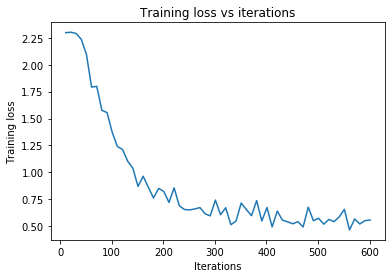

In [13]:
neural_net2.plot_train()

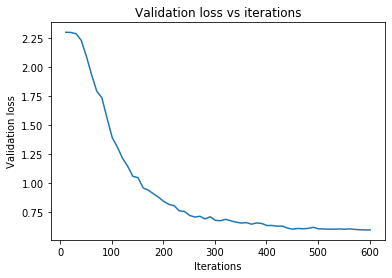

In [14]:
neural_net2.plot_val()

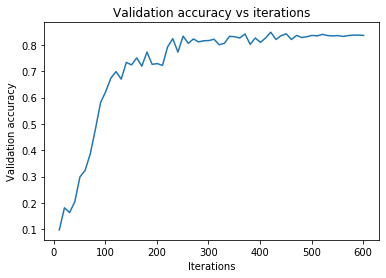

In [15]:
neural_net2.plot_val_accuracies()

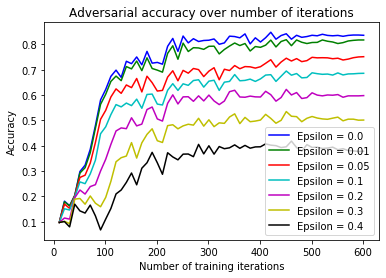

In [16]:
neural_net2.plot_adversarial_accuracies()

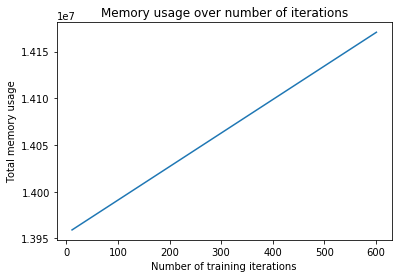

In [17]:
neural_net2.plot_memory_usage()

In [18]:
print(torch.cuda.memory_allocated(0))
print(torch.cuda.memory_cached(0))

7885824
31457280


/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


### Vanilla Training (Wong)

In [22]:
# testing with alpha = 0
neural_net_vanilla = WongNeuralNet()
neural_net_vanilla.fit(train_loader, test_loader, alpha=0, epochs=1)

Starting fit
Epoch: 0


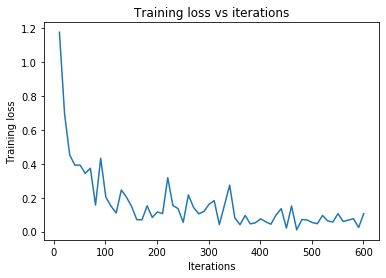

In [23]:
neural_net_vanilla.plot_train()

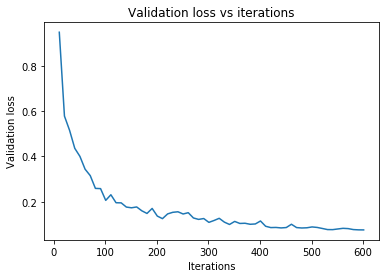

In [24]:
neural_net_vanilla.plot_val()

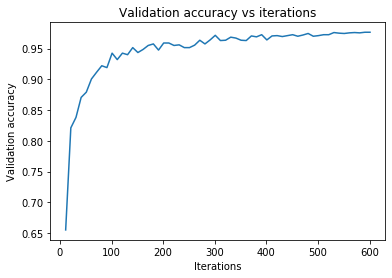

In [25]:
neural_net_vanilla.plot_val_accuracies()

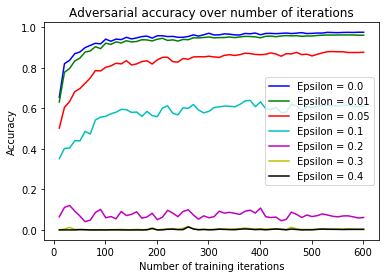

In [26]:
neural_net_vanilla.plot_adversarial_accuracies()

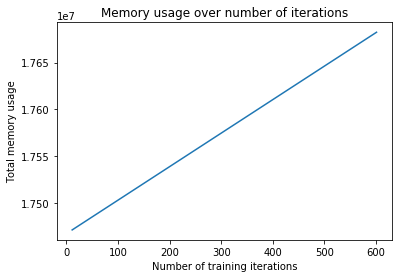

In [27]:
neural_net_vanilla.plot_memory_usage()

## Vanilla Training PreActResNet

In [17]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=100, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=300, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
cifar10_vanilla = WongNeuralNetCIFAR10()

from pytorch_memlab import LineProfiler

# with LineProfiler(cifar10_vanilla.fit) as prof:
cifar10_vanilla.fit(train_loader, test_loader, alpha = 0, epochs = 1, adv=False, epsilon=0)

# prof.display()

adv: False
maxIt: None
Iteration:  1
memory usage: 300009472
in validation
val accuracy: 0.09666666666666666
Iteration:  11
memory usage: 300013056
in validation
val accuracy: 0.23666666666666666
Iteration:  21
memory usage: 300016640
in validation
val accuracy: 0.3
Iteration:  31
memory usage: 300020224
in validation
val accuracy: 0.29
Iteration:  41
memory usage: 300023808
in validation
val accuracy: 0.3466666666666667
Iteration:  51
memory usage: 300027392
in validation
val accuracy: 0.31666666666666665
Iteration:  61
memory usage: 300030976
in validation
val accuracy: 0.3933333333333333
Iteration:  71
memory usage: 300034560
in validation
val accuracy: 0.42
Iteration:  81
memory usage: 300038144
in validation
val accuracy: 0.36
Iteration:  91
memory usage: 300041728
in validation
val accuracy: 0.43666666666666665
Iteration:  101
memory usage: 300045312
in validation
val accuracy: 0.37
Iteration:  111
memory usage: 300048896
in validation
val accuracy: 0.37666666666666665
Iteration:

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:893: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


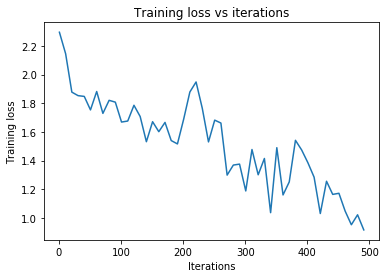

In [8]:
cifar10_vanilla.plot_train()

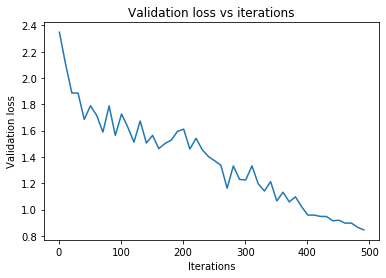

In [9]:
cifar10_vanilla.plot_val()

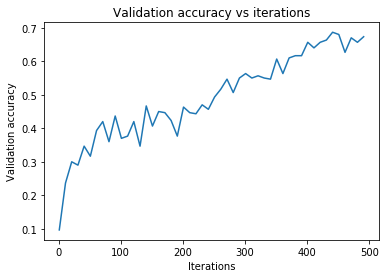

In [10]:
cifar10_vanilla.plot_val_accuracies()

## Boosted Training MNIST

In [11]:
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ]))

test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ]))


# train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=2000, shuffle=False)

smallerdataset = torch.utils.data.Subset(datasets.MNIST, range(5000))
wl, wlweights = SchapireWongMulticlassBoosting(BoostedWongNeuralNet, 50, datasets.MNIST, advDelta=0, alphaTol=1e-10, adv=False, maxIt=5, predictionWeights=False)
for data in test_loader:
    val_X = data[0]
    val_y = data[1]
    break


ensemble = Ensemble(wl, wlweights)
predictions = ensemble.schapirePredict(val_X.to(cuda), 10)
print((predictions == val_y.numpy()).astype(int).sum()/len(predictions))

NameError: name 'SchapireWongMulticlassBoosting' is not defined

In [ ]:
ensemble = Ensemble(wl, [1, 1, 1])
predictions = ensemble.schapirePredict(val_X.to(cuda), 10)
print((predictions == val_y.numpy()).astype(int).sum()/len(predictions))

Prediciton shape:  torch.Size([2000])
0.411


## Boosted Training CIFAR-10


In [27]:
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ]))

test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ]))

from datetime import datetime
# train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=2000, shuffle=False)

t0 = datetime.now()
smallerdataset = torch.utils.data.Subset(datasets.CIFAR10, range(5000))
wl, wlweights = SchapireWongMulticlassBoosting(WongNeuralNetCIFAR10, 1, datasets.CIFAR10, advDelta=0, alphaTol=1e-10, adv=False, maxIt=60, predictionWeights=False)
for data in test_loader:
    val_X = data[0]
    val_y = data[1]
    break


ensemble = Ensemble(wl, wlweights)

predictions = ensemble.schapirePredict(val_X.to(cuda), 10)
print("Finished With: ", (predictions == val_y.numpy()).astype(int).sum()/len(predictions))
print("In ", (datetime.now()-t0).total_seconds(), " s")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------------------------------------------
Training 0th weak learning
Files already downloaded and verified
adv: False
maxIt: 60
Iteration:  1
memory usage: 286445056
val accuracy: 0.115
Iteration:  11
memory usage: 286448640
val accuracy: 0.14
Iteration:  21
memory usage: 286452224
val accuracy: 0.24
Iteration:  31
memory usage: 286455808
val accuracy: 0.295
Iteration:  41
memory usage: 286459392
val accuracy: 0.31
Iteration:  51
memory usage: 286462976
val accuracy: 0.39
targets: tensor([6, 9, 9,  ..., 9, 1, 1])
Full Accuracy:  0.28672
Alpha:  0.21052260702268455


RuntimeError: CUDA out of memory. Tried to allocate 250.00 MiB (GPU 0; 11.17 GiB total capacity; 9.48 GiB already allocated; 166.62 MiB free; 10.58 GiB reserved in total by PyTorch)

## Memory-less CIFAR 10

In [7]:
def runMemlessCifarBoosting(numWL, maxIt, epochs):
    train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.Compose([
                transforms.ToTensor(),
                ]))

    test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.Compose([
                transforms.ToTensor(),
                ]))

    from datetime import datetime
    # train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=100, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=200, shuffle=False)
    for data in test_loader:
        val_X = data[0]
        val_y = data[1]
        break

    t0 = datetime.now()
    smallerdataset = torch.utils.data.Subset(datasets.CIFAR10, range(5000))
    # instance.fit
    # class.fit
    # from pytorch_memlab import LineProfiler

    # with LineProfiler(SchapireWongMulticlassBoostingMemoryLess) as prof:
    wl, wlweights = SchapireWongMulticlassBoostingMemoryLess(WongNeuralNetCIFAR10, numWL, datasets.CIFAR10, advDelta=0, alphaTol=1e-10, adv=False, maxIt=maxIt, predictionWeights=False, epochs=1)

    # prof.display()

    # for data in test_loader:
    #   val_X = data[0]
    #   val_y = data[1]
    #   break


    ensemble = Ensemble(wl, wlweights)

    predictions = ensemble.schapirePredict(val_X.to(cuda), 10)
    print("Finished With: ", (predictions == val_y.numpy()).astype(int).sum()/len(predictions))
    print("In ", (datetime.now()-t0).total_seconds(), " s")

In [8]:
runMemlessCifarBoosting(10, 20, epochs=1)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------------------------------------------
Training 0th weak learning
Files already downloaded and verified
adv: False
maxIt: 20


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/cifar.py:118: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img, target = self.data[index], self.targets[index]


Iteration:  1
memory usage: 144093184
Iteration:  11
memory usage: 144096768


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:893: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


targets: tensor([6, 9, 9,  ..., 9, 1, 1])
Full Accuracy:  0.23538
Alpha:  0.15157240484338735
After newest WL score is:  0.22
----------------------------------------------------------------------------------------------------
Training 1th weak learning
Files already downloaded and verified
adv: False
maxIt: 20
Iteration:  1
memory usage: 280266240
Iteration:  11
memory usage: 280269824
targets: tensor([6, 9, 9,  ..., 9, 1, 1])
Full Accuracy:  0.25826
Alpha:  0.17699762181328318
After newest WL score is:  0.26
----------------------------------------------------------------------------------------------------
Training 2th weak learning
Files already downloaded and verified
adv: False
maxIt: 20
Iteration:  1
memory usage: 142487552
Iteration:  11
memory usage: 142491136
targets: tensor([6, 9, 9,  ..., 9, 1, 1])
Full Accuracy:  0.25722
Alpha:  0.15960732146338227
After newest WL score is:  0.245
---------------------------------------------------------------------------------------------

Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode=RGB size=32x32 at 0x7FB3F87CE2E8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/PIL/Image.py", line 634, in __del__
    self.__exit__()
  File "/usr/local/lib/python3.6/dist-packages/PIL/Image.py", line 596, in __exit__
    if hasattr(self, "fp") and getattr(self, "_exclusive_fp", False):
KeyboardInterrupt


KeyboardInterrupt: 

In [8]:
runMemlessCifarBoosting(10, 400, 1)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------------------------------------------
Training 0th weak learning
Files already downloaded and verified
adv: False
maxIt: 400


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/cifar.py:118: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img, target = self.data[index], self.targets[index]


Iteration:  1
memory usage: 144093184
Iteration:  11
memory usage: 144096768
Iteration:  21
memory usage: 144100352
Iteration:  31
memory usage: 144103936
Iteration:  41
memory usage: 144107520
Iteration:  51
memory usage: 144111104
Iteration:  61
memory usage: 144114688
Iteration:  71
memory usage: 144118272
Iteration:  81
memory usage: 144121856
Iteration:  91
memory usage: 144125440
Iteration:  101
memory usage: 144129024
Iteration:  111
memory usage: 144132608
Iteration:  121
memory usage: 144136192
Iteration:  131
memory usage: 144139776
Iteration:  141
memory usage: 144143360
Iteration:  151
memory usage: 144146944
Iteration:  161
memory usage: 144150528
Iteration:  171
memory usage: 144154112
Iteration:  181
memory usage: 144157696
Iteration:  191
memory usage: 144161280
Iteration:  201
memory usage: 144164864
Iteration:  211
memory usage: 144168448
Iteration:  221
memory usage: 144172032
Iteration:  231
memory usage: 144175616
Iteration:  241
memory usage: 144179200
Iteration: 

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:893: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


targets: tensor([6, 9, 9,  ..., 9, 1, 1])
Full Accuracy:  0.59968
Alpha:  0.6258673453849011
----------------------------------------------------------------------------------------------------
Training 1th weak learning
Files already downloaded and verified
adv: False
maxIt: 400
Iteration:  1
memory usage: 279479808
Iteration:  11
memory usage: 279483392
Iteration:  21
memory usage: 279486976
Iteration:  31
memory usage: 279490560
Iteration:  41
memory usage: 279494144
Iteration:  51
memory usage: 279497728
Iteration:  61
memory usage: 279501312
Iteration:  71
memory usage: 279504896
Iteration:  81
memory usage: 279508480
Iteration:  91
memory usage: 279512064
Iteration:  101
memory usage: 279515648
Iteration:  111
memory usage: 279519232
Iteration:  121
memory usage: 279522816
Iteration:  131
memory usage: 279526400
Iteration:  141
memory usage: 279529984
Iteration:  151
memory usage: 279533568
Iteration:  161
memory usage: 279537152
Iteration:  171
memory usage: 279540736
Iteration:

KeyboardInterrupt: 

In [ ]:
runMemlessCifarBoosting(200, 30)

# Method for incorporating Wong's method into boosting

* Decision trees:
  * Take the worst-case perturbation for each example
  * Overall cost: summed cost of the worst-case perturbation on each example
  * Apply schapire's update on cost matrix

[ 1. 1. 1.  1. -(k - 1).  1. 1 ]

* Neural networks
  * Sample minibatches based on the sums of absolute values within each row
  * Partition each minibatch into k groups
    * Find which k has the largest associated cost for each example in the minibatch (by looking at the cost matrix)
    * 

For each example:
* Find the worst class
[k1, k2, k3, .. km] = K

randomly initizlize delta
find cross_entropy(prediction(batch + delta), K)
delta += alpha * sign(gradient)


Cross-entropy loss:

Cost matrix row:
1 5 -2

Prediction:
.1 .8 .1
Ideal prediction:
0 0 1

Decision tree prediction:
0 1 0



Steps to transform a row of the cost matrix:
* negate
* add such that the smallest elt. is 0
* normalize (so the sum is 1)
  * -1 -5 2
  * 4 0 7
  * .37 0 .63
  * 0 1 0: bad


In [ ]:
import torch
def cross_entropy(pred, soft_targets):
  logsoftmax = nn.LogSoftmax()
  return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))

costs = torch.tensor([[.37, 0., .63]])

pred1 = torch.tensor([[1., 0., 0.]])
pred2 = torch.tensor([[0., 1., 0.]])
pred3 = torch.tensor([[0., 0., 1.]])
print("costs:")
print(cross_entropy(pred1, costs), cross_entropy(pred2, costs), cross_entropy(pred3, costs))

costs:
tensor(1.1814) tensor(1.5514) tensor(0.9214)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


In [ ]:
from scipy.special import softmax
costs = np.array([1., 5., -2.])
negated = costs * -1.
softmax = softmax(negated)
print(softmax)

[4.73847131e-02 8.67881295e-04 9.51747406e-01]
